# Plant Leaf image pre-processing for classifcation and disease detection

Import Packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio
from scipy import ndimage

Open original plant leaf image and also plot the histogram for the same.

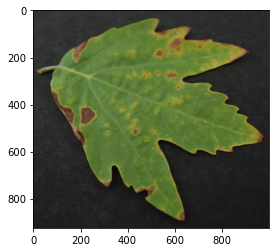

<BarContainer object of 256 artists>

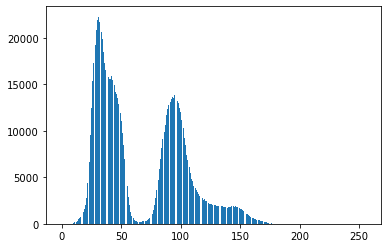

In [2]:
#pomegranate.jpg, chinar.jpg, gauva.jpg, jamun.jpg,lemon.jpg 
original_image = cv2.imread('chinar.jpg')
img=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# print(np.shape(img))
# print(img)
plt.bar(range(256),
        cv2.calcHist([img],[0],None,[256],[0,256]).ravel())

## Image segmentation using K-Means Clustering.
Role of this algorithm in this project is to classify the image pixels into different no. of important groups so that all possibilities will be considered and preserved by strong artificial edges.

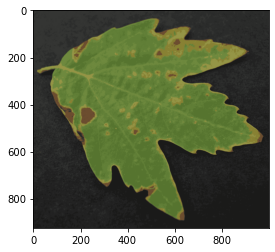

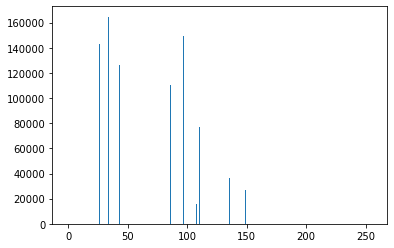

In [3]:
#K-Means Clustering
vectorized = img.reshape((-1,3))
# print(np.shape(vectorized))
# print(vectorized)
vectorized = np.float32(vectorized)
# print(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
# print(center)
result = center[label.flatten()]
result_image = result.reshape((img.shape))
plt.imshow(result_image)
plt.show()
plt.bar(range(256),
        cv2.calcHist([result_image],[0],None,[256],[0,256]).ravel())
imageio.imwrite('clustered.JPG',result_image)

## Conversion from RGB to Grayscale Image:
Three channel RGB image is then converted to one channel Gray Scale image. Also, the background noise (or cluster defining the background image) is removed by Histogram analysis of clustered image.

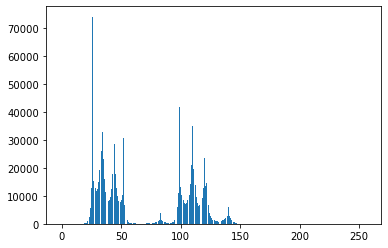

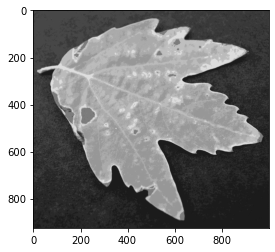

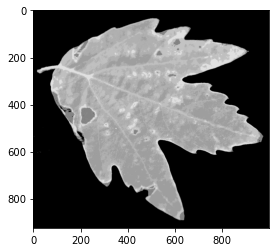

In [4]:
clustered_img = cv2.imread('clustered.JPG') #read input image
img1 = cv2.cvtColor(clustered_img, cv2.COLOR_BGR2RGB)
# plt.imshow(img1)
# plt.show()
img = cv2.cvtColor(clustered_img, cv2.COLOR_BGR2GRAY) #convert from BGR to gray
# print('image dimensions:',np.shape(img))
plt.bar(range(256),cv2.calcHist([img],[0],None,[256],[0,256]).ravel())
plt.show()
img = img.astype('int32') #pixel values converted to dtype int32
plt.imshow(img, cmap = plt.get_cmap('gray')) #plot image
plt.show()
prop = img.shape
max = 60 # to be decided by histogram analysis of clustered image.
img1 = [[0 if img[i][j]<=max else img[i][j] for j in range(prop[1])]for i in range(prop[0])]
plt.imshow(img1, cmap = plt.get_cmap('gray'))
plt.show()

## Noise reduction by applying Gaussian Blur:
Mathematics involved in this edge detection method involves the calculation of derivatives, it is highly sensitive to image noise. Among mean, median, adaptive median, Gaussian etc. noise removal filters, Gaussian is known for preserving the edges in the image.

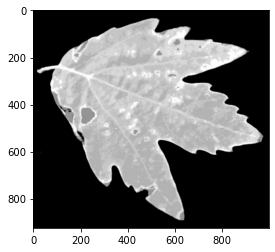

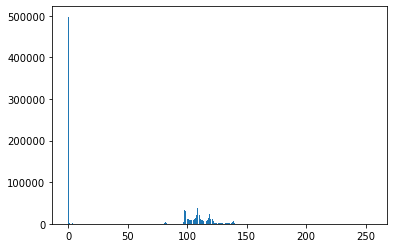

In [5]:
img_guassian_filter = ndimage.gaussian_filter(img1, sigma=1.0) 
plt.imshow(img_guassian_filter, cmap = plt.get_cmap('gray'))
plt.show()
img_guassian = np.uint8(img_guassian_filter)
plt.bar(range(256),cv2.calcHist([img_guassian],[0],None,[256],[0,256]).ravel())
plt.show()

Normalize this image for further analysis

In [6]:
def Normalize(img):
    img = img/np.max(img)
    return img

## Gradient Calculation using Sobel Filter:
Gradient calculation is basically calculating the derivative of image which also means that detecting the high intensity value changes in the image. First gradient in x and y direction is calculated then merged together to form a magnitude image which contains every possible edge in the image.

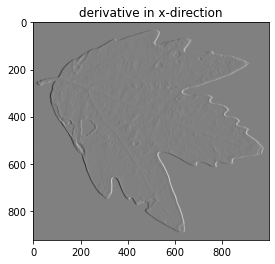

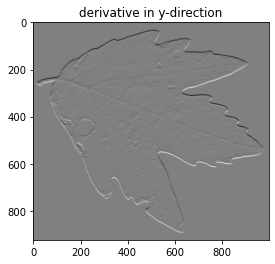

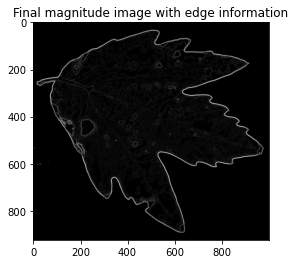

In [7]:
# sobel filter to find derivative in x and y direction
def SobelFilter(img, direction):
    if(direction == 'x'):
        Gx = np.array([[-1,0,+1], [-2,0,+2],  [-1,0,+1]])
        Res = ndimage.convolve(img, Gx)
    if(direction == 'y'):
        Gy = np.array([[-1,-2,-1], [0,0,0], [+1,+2,+1]])
        Res = ndimage.convolve(img, Gy)
    return Res

gx = SobelFilter(img_guassian_filter, 'x')
gx = Normalize(gx)
plt.imshow(gx, cmap = plt.get_cmap('gray'))
plt.title("derivative in x-direction")
plt.show()
gy = SobelFilter(img_guassian_filter, 'y')
gy = Normalize(gy)
plt.imshow(gy, cmap = plt.get_cmap('gray'))
plt.title("derivative in y-direction")
plt.show()
# print(type(gx))
# print(gx.shape)
# img_gx = np.uint8(gx)
# plt.bar(range(256),cv2.calcHist([img_gx],[0],None,[256],[0,256]).ravel())
# plt.show()
# img_gy = np.uint8(gy)
# plt.bar(range(256),cv2.calcHist([img_gy],[0],None,[256],[0,256]).ravel())
# plt.show()
Mag = np.hypot(gx,gy) #G = sqrt((gx)^2 + (gy)^2) magnitude of image
# print(Mag.shape)
plt.imshow(Mag, cmap = plt.get_cmap('gray'))
plt.title("Final magnitude image with edge information")
plt.show()
Gradient = np.degrees(np.arctan2(gy,gx))
# print(Gradient.shape)
# print(Gradient)

## Non-Maximum Suppression:
Magnitude image consists of all strong and weak edges. Also, some of the edges are thicker while some are thinner which results into loss of clarity in important part of image. Gradient calculation beside of magnitude also gives angle orientation of each pixel. We can use this information for thinning out the thicker ones.

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.



Final output image to be used for disease detection:


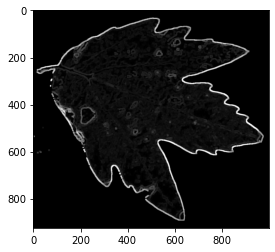

In [8]:
# non-maxima suppression i.e. the pixel closest to the gradient direction is used as the estimate
def NonMaxSup(Gmag, Grad):
    NMS = np.zeros(Gmag.shape)
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= -22.5 and Grad[i,j] <= 22.5) or (Grad[i,j] <= -157.5 and Grad[i,j] >= 157.5)):
                if((Gmag[i,j] > Gmag[i,j+1]) and (Gmag[i,j] > Gmag[i,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 22.5 and Grad[i,j] <= 67.5) or (Grad[i,j] <= -112.5 and Grad[i,j] >= -157.5)):
                if((Gmag[i,j] > Gmag[i+1,j+1]) and (Gmag[i,j] > Gmag[i-1,j-1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 67.5 and Grad[i,j] <= 112.5) or (Grad[i,j] <= -67.5 and Grad[i,j] >= -112.5)):
                if((Gmag[i,j] > Gmag[i+1,j]) and (Gmag[i,j] > Gmag[i-1,j])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] >= 112.5 and Grad[i,j] <= 157.5) or (Grad[i,j] <= -22.5 and Grad[i,j] >= -67.5)):
                if((Gmag[i,j] > Gmag[i+1,j-1]) and (Gmag[i,j] > Gmag[i-1,j+1])):
                    NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0

    return NMS

WINMS = NonMaxSup(Mag,Gradient)
WINMS = Normalize(WINMS)
# plt.imshow(WINMS, cmap = plt.get_cmap('gray'))
# plt.show()
imageio.imwrite('WINMS.jpg',WINMS)
kernel = np.ones((5,5), np.uint8) 
imgd = cv2.dilate(WINMS, kernel, iterations=1)
plt.imshow(imgd, cmap = plt.get_cmap('gray'))
print("\nFinal output image to be used for disease detection:")
plt.show()

## Double Thresholding and edge tracking by Hysteresis:
The result of double thresholding is an image with only two-pixel values (strong and weak). By edge tracking by hysteresis weak pixels are transformed into strong edges if and only if it is surrounded by at least one strong pixel.


Final output image to be used for plant classification:


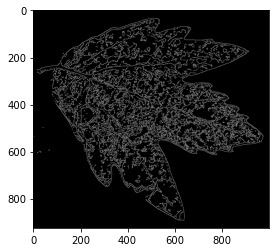

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [9]:
# Double threshold Hysterisis
def DoThreshHyst(img):
    highThresholdRatio =0.05  #0.32
    lowThresholdRatio = 0.01    #0.3
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    
    for i in range(1,h-1):
        for j in range(1,w-1):
            if(GSup[i,j] > highThreshold):
                GSup[i,j] = 1
            elif(GSup[i,j] < lowThreshold):
                GSup[i,j] = 0
            else:
                if((GSup[i-1,j-1] > highThreshold) or 
                    (GSup[i-1,j] > highThreshold) or
                    (GSup[i-1,j+1] > highThreshold) or
                    (GSup[i,j-1] > highThreshold) or
                    (GSup[i,j+1] > highThreshold) or
                    (GSup[i+1,j-1] > highThreshold) or
                    (GSup[i+1,j] > highThreshold) or
                    (GSup[i+1,j+1] > highThreshold)):
                    GSup[i,j] = 1
                    
    GSup = (GSup == 1) * GSup #remove/clean all the weak edges which are not connected to strong edges
    return GSup

Final_Image = DoThreshHyst(WINMS)
plt.imshow(Final_Image, cmap = plt.get_cmap('gray'))
print("\nFinal output image to be used for plant classification:")
plt.show()
imageio.imwrite('Final_Image.jpg',Final_Image)

## Image Dilation(if required):
Sometimes but not always, Disease spots at very early stage are not traceable even after compete image pre-processing. Also, some deep learning methods may require thicker strong edges which are thinned at non-maximum separation stage. Image dilation basically adds pixels at the boundaries.

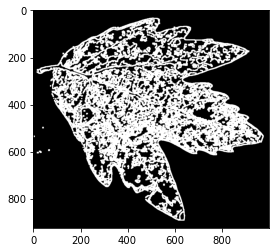

In [10]:
def dilation(image,iterations):
    n = 0
    while(n != iterations):
        img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        (thresh,binary) = cv2.threshold(img, 127,255,cv2.THRESH_BINARY)
        filt = np.ones((5,5), np.uint8) 
    #     print(filt)
        I = binary.shape
        F = filt.shape
    #     print(I)
    #     print(F)
        row = I[0] + F[0] - 1
        column = I[1] + F[1] - 1
    #     print(row, column)
        N = np.zeros((row,column))
        for i in range(I[0]):
            for j in range(I[1]):
        #         N[i+1,j+1] = binary[i][j]
                N[i+np.int((F[0]-1)/2),j+np.int((F[1]-1)/2)] = binary[i][j]
    #     print(N.shape)
    #     plt.imshow(N,'gray')
    #     plt.show()          
        for i in range(I[0]):
            for j in range(I[1]):
                count = 0
                W = N[i:i+F[0],j:j+F[1]]
                for k in range(F[0]):
                    for m in range(F[1]):
                        if W[k,m] != 0.0:
                            count = count + 1
                if count>0:
                    binary[i,j] = 1
                else:
                    binary[i,j] = 0
        n = n+1
    plt.imshow(binary,'gray')
    plt.show()

img = cv2.imread("Final_Image.jpg")
dilation(img,1)


## Conclusion:
1] If image dilation is performed right after Non-Maximum Suppression without performing double thresholding & edge tracking by hysteresis then resultant output image is better suited for disease detection while other edge information (Leaf veins) for plant classification is lost. 
2] On the other hand, if all the steps in algorithm are followed in order but image dilation (last step) is not performed then resultant output image is better suited for plant classification as veins details are retained while disease information is lost. 
    This algorithm is better suited for image pre-processing of plant leaf images. The processed images can then be used further by modern deep learning methods for Plant classification as well as plant disease detection.